In [1]:
import configparser

model_config = "/Users/asadh/Documents/GitHub/gravpop_pipe/tests/model.ini"

In [2]:
import re
import configparser
from gravpop import *

def config_to_dict(config):
    config_dict = {}
    for section in config.sections():
        parts = section.split('.')
        current_dict = config_dict
        for part in parts[:-1]:
            current_dict = current_dict.setdefault(part, {})
        current_dict[parts[-1]] = dict(config.items(section))
    return config_dict

convert_to_list = lambda x: eval(x.replace(', ', "','").replace("[", "['").replace("]", "']"))

def has_empty_function_call(string):
    pattern = r'[^(]*\(\s*\)'
    return re.search(pattern, string) is not None

class Parser:
    def __init__(self, config_file):
        self.config_file = config_file
        self.config = configparser.ConfigParser()
        self.config.read(self.config_file)
        self.config_dict = config_to_dict(self.config)
        self.default_model_order = ['mass', 'redshift', 'spin_magnitude', 'spin_orientation']
        self.default_model_order = [m for m in self.default_model_order if m in self.config_dict["Models"].keys()]
        self._likelihood = None
        self._priors = None
        self._latex_names = None
        self._sampler = None
        self._hyper_posterior = None
        
    def get_list_of_models(self, model_dict):
        models = self.models
        return [models[m] for m in self.default_model_order if m in P.models] + list([v for m,v in models.items() if m not in self.default_model_order])
        
    @property
    def models(self):
        new_names = {}
        for model in self.config_dict['Models'].keys():
            hyper_var_names = convert_to_list(self.config_dict['Variables']['Population'][model])
            var_names = convert_to_list(self.config_dict['Variables']['Event'][model])
            model_call = self.config_dict['Models'][model]
            if has_empty_function_call(model_call):
                new_names[model] = model_call.replace(')',  f'var_names={var_names}, hyper_var_names={hyper_var_names})')
            else:
                new_names[model] = model_call.replace(')',  f', var_names={var_names}, hyper_var_names={hyper_var_names})')
                
        return {key: eval(value) for key, value in new_names.items()}
    
    @property
    def likelihood(self):
        if self._likelihood is None:
            likelihood_items = {key:eval(value) for key, value in P.config_dict['Likelihood'].items()}
            cls = likelihood_items.pop('type', PopulationLikelihood)
            self._likelihood = cls.from_file(event_data_filename=P.config_dict['DataSources']['event_data'],
                                   selection_data_filename=P.config_dict['DataSources']['selection_data'], 
                                   models=self.get_list_of_models(self.models),
                                   **likelihood_items)
            
        return self._likelihood
    
    @property
    def priors(self):
        if self._priors is None:
            import numpyro.distributions as dist
            self._priors = {parameter : eval(prior_string) for parameter, prior_string in P.config_dict['Priors'].items()}
        
        return self._priors
    
    @property
    def latex_names(self):
        if self._latex_names is None:
            self._latex_names = {key: eval(value) for key,value in P.config_dict['Latex'].items()}
        
        return self._latex_names
    
    @property
    def sampler(self):
        if self._sampler is None:
            kwargs = {key:eval(value) for key, value in self.config_dict['Sampler'].items()}
            self._sampler = Sampler(priors = self.priors,
                                    latex_symbols = self.latex_names,
                                    likelihood = self.likelihood,
                                    **kwargs)
            
        return self._sampler
    
    @property
    def hyper_posterior(self):
        if self.sampler.samples is None:
            raise ValueError("Need to run the sampler first")
            
        if self._hyper_posterior is None:
            self._hyper_posterior = HyperPosterior(self.sampler.samples, self.likelihood, models=self.models)
            
        return self._hyper_posterior
        
        
        

In [3]:
P = Parser(model_config)

In [4]:
the_res = pd.read_csv("./lvk_results.csv")
the_res = the_res[['alpha', 'beta', 'mmax', 'mmin', 'lam', 'mpp', 'sigpp', 'delta_m',
       'mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin', 'lamb']]

In [5]:
P.sampler.samples = the_res

(N_events, N_samples_per_event) =  (69, 3194)


In [6]:
P.hyper_posterior.N_effective_cuts()

Calculating Event N_effective ...:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating Selection Function N_effective ...:   0%|          | 0/100 [00:00<?, ?it/s]

,alpha,beta,mmax,mmin,lam,mpp,sigpp,delta_m,mu_chi,sigma_chi,xi_spin,sigma_spin,lamb,min_event_n_effective,pdet_n_effective
0,3.370779,-0.144415,93.747368,4.761213,0.031055,38.192577,8.351158,5.556212,0.248935,0.025979,0.710345,2.169929,2.904672,115.394844,4279.324707
1,3.517452,0.520862,78.111069,5.738334,0.047306,34.232548,3.635846,3.414667,0.331575,0.028306,0.683327,3.602843,3.145157,26.495872,3600.812988
2,3.757179,1.481396,92.886024,5.266328,0.070807,30.688763,5.566110,3.365682,0.319693,0.028831,0.926068,2.808982,3.722391,67.765617,3555.141357
3,3.157693,0.594983,87.589600,4.191087,0.033773,33.437042,2.680766,6.744849,0.321885,0.041765,0.772619,3.193782,2.287428,132.505844,5366.234375
4,3.336573,1.007213,84.190620,3.587009,0.024364,33.802723,4.793861,9.856162,0.278284,0.043146,0.739161,1.259861,2.555573,73.731094,4620.883301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.803866,1.010220,76.935326,5.779393,0.063113,33.121979,3.871289,4.066170,0.311108,0.044892,0.664484,2.662875,4.994095,29.893761,3468.341309
96,2.967092,0.435689,95.552704,4.389737,0.088976,30.525860,6.537283,5.438847,0.236462,0.023730,0.698005,1.197365,1.476895,88.484863,3308.516113
97,3.509386,1.341041,84.431412,5.806120,0.074017,30.415377,6.738914,3.059471,0.299192,0.024317,0.737879,1.269090,4.056849,55.645039,3159.832764
98,3.569603,0.659095,89.116058,5.164698,0.058196,35.065655,6.940872,3.939376,0.297731,0.037536,0.784180,2.247391,2.410170,157.587875,5406.819824


Computing Spin Magnitude Model on the Grid:   0%|          | 0/100 [00:00<?, ?it/s]

<Axes: xlabel='$\\chi$', ylabel='$p(\\chi | \\Lambda)$'>

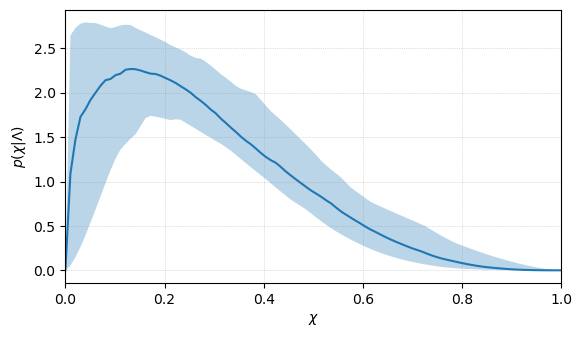

In [11]:
P.hyper_posterior.spin_magnitude_plot.spin_generic_marginal_plot()